# OCR Agent from scratch:

* [Data](Data-Sources.ipynb)
* Utilities
* Extract layout features and visual tokens
    * [Cells and grid-lines (tables)](Data-Extraction-1.ipynb)
    * [Text-lines, word-level objects, char-level tokens](Data-Extraction-2.ipynb)
* [Generate training data](Data-Extraction-3.ipynb)
* [Model architecture](Model-Training.ipynb)
* [Traversal strategies](Traversal-Layout.ipynb)
* [Reader Agent](Agent-FSM.ipynb)
* [Leverage synthetic training data](Data-Gen.ipynb)
* [Optimization for production](Optimization.ipynb)


### Tech stack
    Our main tools in this project will be `OpenCV` and `PyTorch` libraries.

## Layout features and visual tokens
We will be using [OpenCV utilities](https://docs.opencv.org/3.4/d9/d8b/tutorial_py_contours_hierarchy.html)
and a few simple heuristics to seed the initial segmentation we can start to learn from iteratively.

( Default parameters set for the resolution of `250-350 dpi`:
for lower / higher resolutions parameters should be readjusted. )

In [1]:
import cv2
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from PIL import Image
from matplotlib import pyplot as plt
from matplotlib import patches
from pathlib import Path

<a name="util"></a>

<a name="util"></a>

## Basic utilities

In [2]:
def resample(image, f):
    if f == 1:
        return image
    h, w = image.shape[:2]
    return cv2.resize(image, (max(int(round(w/f)), 1), max(int(round(h/f)), 1)), cv2.INTER_AREA)
    

In [3]:
def binarize(image, kernel):
    image = cv2.erode(image, np.ones(kernel, np.uint8), iterations=1)
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY)[1]


In [4]:
def sharpen(image):
    return cv2.filter2D(image, -1, np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]]))


In [5]:
def load_image(source, kernel=(2, 2)):
    return binarize(cv2.imread(f'./data/images/{source}.png', cv2.IMREAD_GRAYSCALE), kernel=kernel)


In [6]:
def load_info(source):
    content = pd.read_csv(f'./data/content/{source}.csv.gz')
    if content.loc[0,'num-inputs'] == 0:
        return content, None
    inputs = pd.read_csv(f'./data/inputs/{source}.csv.gz')
    return content, inputs


### Data samples
Our data consist of the images of pages extracted from the downloaded blank pdf tax-forms for IRS and Canada Revenue Agency in English and French languages.

In [7]:
samples = [str(x)[12:-4] for x in Path('./data/images').glob('*.png')]
len(samples)

8633

In [8]:
source = np.random.choice(samples)

In [9]:
print(source)
image = load_image(source)
print(set(image.flatten()))
#Image.fromarray(image)

cnd-gst189.fr-3
{0, 255}


#### Common definitions

In [10]:
CHAR = 1
CELL = 2
HLINE = 3
VLINE = 4
BLOCK = 5
INPUT = 6
SPACE = 7

BOX = ['left','top','width','height']

In [11]:
def visual_check(output, visual, figsize=(8, 8)):
    """
    see segmentation output
    """
    if not visual: return
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(output, 'gray')
    plt.show()
    

### Extract high-level blocks
The simple heuristics we follow: `downsample` to reduce coords-detection jitter and speedup processing; and apply `erosion` to connect spatially related components. Using those with different parameters we can extract different levels of structural hierarchy.

In [12]:
def extract_blocks(mask, f=4, kernel=(11, 11), visual=False):
    """
    extract high-level structural elements
    from the original (whight background) image fragment
    """
    if mask.shape[0] < 4 * f or mask.shape[1] < 4 * f:
        return np.array([])
    output = cv2.erode(mask, np.ones(kernel, np.uint8), iterations=1)
    output = resample(output, f)
    output = cv2.erode(output, np.ones(kernel, np.uint8), iterations=1)
    output = cv2.threshold(output, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    visual_check(output, visual)
    contours,_ = cv2.findContours(output, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return np.array([cv2.boundingRect(c) for c in contours]) * f


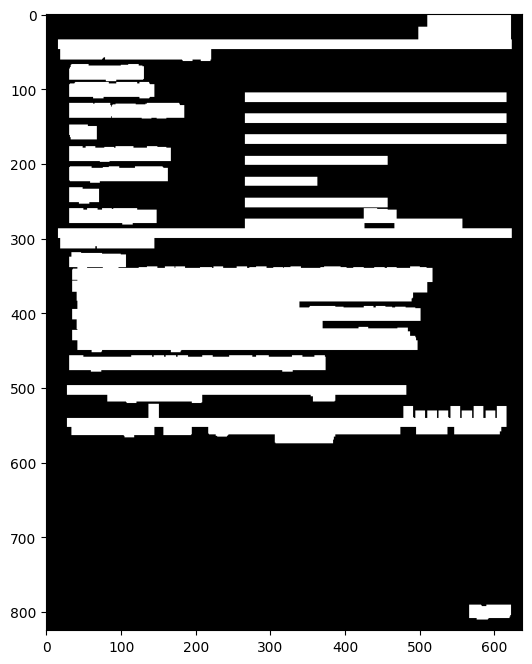

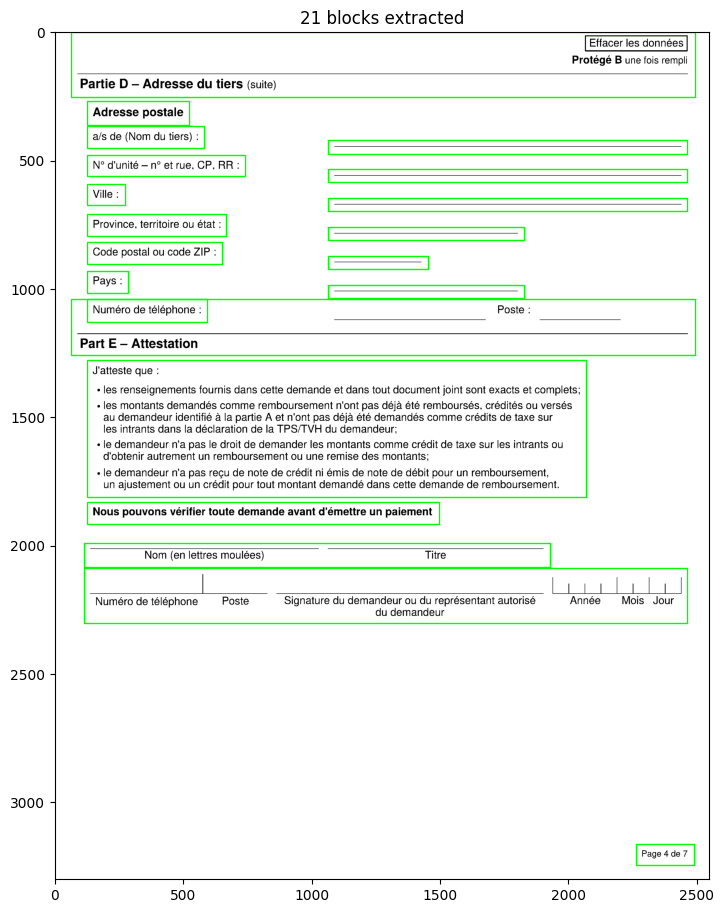

In [13]:
blocks = extract_blocks(image, visual=True)

fig, ax = plt.subplots(figsize=(11, 11))
ax.imshow(image, 'gray')
for b, (x, y, w, h) in enumerate(blocks):
    ax.add_patch(patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='lime', facecolor='none'))
plt.title(f'{len(blocks)} blocks extracted')
plt.show()

In [14]:
def filter_boxes(boxes, shape, scale=13, reverse=True):
    """
    keep only one level hierarchy; either parents or the children
    """
    order = np.array(sorted(boxes, key=lambda b:b[2]*b[3], reverse=reverse))
    matrix = np.zeros((shape[0]//scale, shape[1]//scale))
    x, y, w, h = order[0][:4]//scale
    matrix[y:y + h,x:x + w] = 1
    filtered = [order[0]]
    for b in np.array(order)[1:]:
        x, y, w, h = b[:4]//scale
        # drop overlap
        if np.sum(matrix[y:y + h,x:x + w]) > 0:
            continue
        matrix[y:y + h,x:x + w] = 1
        filtered.append(b)
    return np.array(filtered)


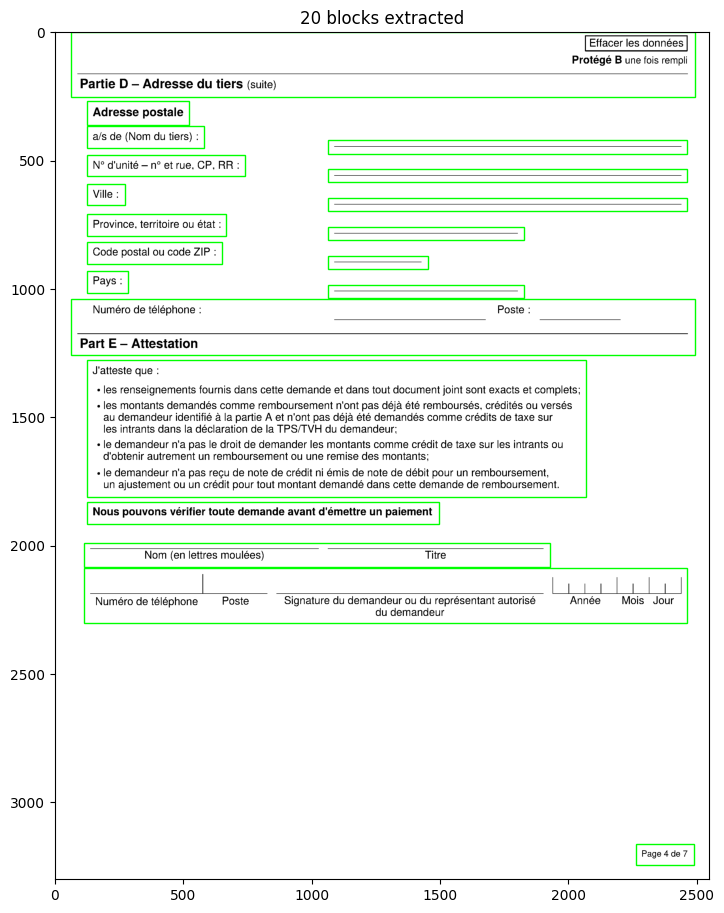

In [15]:
blocks = filter_boxes(blocks, image.shape)

fig, ax = plt.subplots(figsize=(11, 11))
ax.imshow(image, 'gray')
for b, (x, y, w, h) in enumerate(blocks):
    ax.add_patch(patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='lime', facecolor='none'))
plt.title(f'{len(blocks)} blocks extracted')
plt.show()

Takeaway: few paragraphs plain text segmentation is trivial; forms with complex layout may present a challenge.